In [77]:
#!/usr/bin/python
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb
import csv
from collections import defaultdict
import redis
import json
import time
import sklearn.utils
### simple example
# load file from text file, also binary buffer generated by xgboost
# dtrain = xgb.DMatrix('./demo/rank_aida/mq2008.train')

# dtest = xgb.DMatrix('./demo/rank_aida/mq2008.test')

In [78]:
conn = redis.Redis(password='3oSYTdtZjsuSigRWLcG6VJt9gm4IMvYjQiqsSuGcAc-U4gMNpWGERAevXi9_SHNrn19piz7bBJG0iTLgx7DvknLHTECcHYrqmWb2rsuCWs89svKmhKDD_aMYaXq8IhSeg_89ooPZb0AqLRyR1-fa1zVjrh2UuV0sWFGSk5SjtW0', 
                   host='localhost', port=7380, decode_responses=True)

def get_feature_results(exp_id, d_t, data_source='aida_conll'):
    fea_res = conn.lrange('result:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t), 0, -1)
    fea_vecs = [json.loads(res) for res in fea_res]
    return fea_vecs

In [79]:
def get_dataset_info(exp_id, d_t, data_source='aida_conll', can_size=50):
    valid_mens_size = conn.scard('valid_qry_ids:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    no_g_can_info_size = conn.scard('no_g_candidate_info:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    missed_g_candidate_size = conn.scard('missed_g_candidate:::::' + str(exp_id) + ':::::' + data_source + 
                                         ':::::' + str(d_t) + ':::::' + str(can_size))
    no_candidate_size = conn.scard('no_candidate:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    return valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size

In [80]:
def fetch_all_features(exp_id, data_type, data_source='aida_conll'):
    res_feas = get_feature_results(exp_id, data_type, data_source)
    res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[1:-1] + [res[-1]] for res in res_feas]
    res_feas_ids = np.array(res_feas_ids, dtype=np.float64)
    return res_feas_ids

In [81]:
res_feas = get_feature_results('basic_fea_ctx', 'testb', 'aida_conll')
res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[1:-1] + [res[-1]] for res in res_feas]

In [82]:
res_feas_ids[:5]

[['401978',
  0.20262246412667,
  0.658337456704602,
  64,
  0.104817066748508,
  60,
  0,
  0.1459760771106724,
  9.027640523807117e-06,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 ['401978',
  0.658337456704602,
  0.658337456704602,
  64,
  0.615393591012299,
  60,
  0,
  0.3204041342468935,
  1.9814845031968045e-05,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['401978',
  0.0103908955962395,
  0.658337456704602,
  64,
  0.0421874524805695,
  60,
  0,
  0.008129137150156776,
  5.027325669582324e-07,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['401978',
  0.00445324096981692,
  0.658337456704602,
  64,
  0.0276114022346727,
  60,
  0,
  0.0034839159214957614,
  2.1545681441067104e-07,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['401978',
  0.0202869866402771,
  0.658337456704602,
  64,
  0.0202048726381804,
  60,
  0,
  0.017187318546045754,
  1.062920284425977e-06,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [83]:
res_feas[:5]

[["(401978, 'Hellas_Verona_F.C.')",
  0.20262246412667,
  0.658337456704602,
  64,
  0.104817066748508,
  60,
  0,
  0.1459760771106724,
  9.027640523807117e-06,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 ["(401978, 'Verona')",
  0.658337456704602,
  0.658337456704602,
  64,
  0.615393591012299,
  60,
  0,
  0.3204041342468935,
  1.9814845031968045e-05,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ["(401978, 'Verona,_Wisconsin')",
  0.0103908955962395,
  0.658337456704602,
  64,
  0.0421874524805695,
  60,
  0,
  0.008129137150156776,
  5.027325669582324e-07,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ["(401978, 'Verona,_Pennsylvania')",
  0.00445324096981692,
  0.658337456704602,
  64,
  0.0276114022346727,
  60,
  0,
  0.0034839159214957614,
  2.1545681441067104e-07,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ["(401978, 'Verona,_New_York')",
  0.0202869866402771,
  0.658337456704602,
  64,
  0.0202048726381804,

In [84]:
def fetch_all_features_delete_max_prior(exp_id, data_type, data_source='aida_conll'):
    res_feas = get_feature_results(exp_id, data_type, data_source)
    res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[1:2] + [res[2] if res[2]!=0 else res[1]] + res[3:] for res in res_feas]
    res_feas_ids = np.array(res_feas_ids, dtype=np.float64)
    return res_feas_ids

In [171]:
def trans_data(data):
    d_np = data[:, 1:-1]
    print(d_np)
    d_labels = data[:, -1]
    print(d_labels)
    idxs = np.where(d_labels == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_labels)) - idxs
    xgb_data = xgb.DMatrix(data=d_np, label=d_labels)
    xgb_data.set_group(d_groups)
    return xgb_data

In [172]:
trans_data(np.array([
    [100, 0, 1, 2, 3, 1],
    [100, 0, 1, 2, 3, 0],
    [101, 0, 1, 2, 3, 1],
    [101, 0, 1, 2, 3, 0]
]))

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
[1 0 1 0]


In [155]:
def combine_features(original_feas, new_features):
    men_id_feas_dict = defaultdict(list)
    print("Building idx for new features...")
    for fea in new_features:
        men_id_feas_dict[fea[0]].append(fea)
    #for k, v in men_id_feas_dict.items():
    #    print(k)
    #    print(v)
    comb_feas = []
    pre_men_id = 0
    print("Combine original and new features...")
    for fea_idx, fea in enumerate(original_feas):
        #print('Processing: [%d] %s' % (fea_idx, fea))
        if pre_men_id == fea[0]:
            #print('skip')
            continue
        else:
            pre_men_id = fea[0]
            fea_size = len(men_id_feas_dict[fea[0]])
            res = np.append(original_feas[fea_idx: fea_idx + fea_size, :-1], np.array(men_id_feas_dict[fea[0]])[:, 1:], axis=1)
            #print('res:', res)
            comb_feas.append(res)
    return np.concatenate(comb_feas, axis=0)

In [156]:
combine_features(np.array([[10,0,1],[10,1,0],[10,2,0], [11,0,1], [11,1,0], [11,2,0]]), 
                 np.array([[10,0,1],[10,-1,0],[10,-2,0], [11,0,1], [11,-1,0], [11,-2,0]]))

Building idx for new features...
Combine original and new features...


array([[10,  0,  0,  1],
       [10,  1, -1,  0],
       [10,  2, -2,  0],
       [11,  0,  0,  1],
       [11,  1, -1,  0],
       [11,  2, -2,  0]])

In [87]:
def evalerror(preds, dt, d_tal_size):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = float(len(matched_ids)) / d_tal_size
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1

In [227]:
from collections import defaultdict
def evalerror_detail_log(preds, dt, dummy=0):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    correct_results = {}
    wrong_results = {}
    duplicates_results = {}
    group_info = {}
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            correct_results[q_id] = pre_res
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
            else:
                duplicates_results[q_id] = pre_res
        else:
            wrong_results[q_id] = pre_res
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = precision
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1, correct_results, wrong_results, duplicates_results

In [89]:
from collections import defaultdict
from ast import literal_eval
def get_groups_results(preds, dt, d_tal_size, res_features):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
#     correct_results = {}
#     wrong_results = {}
#     duplicates_results = {}
#     group_info = {}
#     matched_ids = []
    correct_res_groups = []
    wrong_res_groups = []
    dup_res_groups = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        pre_res_feas = res_features[q_id: x + q_id]
        pred_q_id, pred_ent = literal_eval(res_features[q_id+np.argmax(pre_res)][0])
        
        if(preds[q_id] == max(pre_res)):
            correct_res_groups.append([pred_q_id, pred_ent])
        else:
            wrong_res_groups.append([pred_q_id, pred_ent])
        q_id += x
#     precision = float(len(matched_ids)) / len(d_groups)
#     recall = float(len(matched_ids)) / d_tal_size
#     f1 = 2 * precision * recall / (precision + recall)
    return correct_res_groups, wrong_res_groups

### Check whether there is a link between ent_1 and ent_2

In [90]:
import psycopg2
conn_psql_kongzi2 = psycopg2.connect(database='aida', user='zding', password='dingzishuo', host='localhost',
                                     port=5432)

In [91]:
def fetch_inlinks_by_ent(ent):
    cur = conn_psql_kongzi2.cursor()
    sql = "SELECT _id FROM wikipedia_links_2014 WHERE target=%s;"
    cur.execute(sql, (ent,))
    rows = cur.fetchall()
    cur.close()
    return rows

# fetch an entity's outlinks with duplicates
def fetch_outlinks_by_ent(ent):
    cur = conn_psql_kongzi2.cursor()
    sql = "SELECT target FROM wikipedia_links_2014 WHERE _id=%s;"
    cur.execute(sql, (ent,))
    rows = cur.fetchall()
    cur.close()
    return rows

In [92]:
def fetch_entity_by_mention_emnlp17(mention):
    # print(mention)
    cur = conn_psql_kongzi2.cursor()
    # do a PostgreSQL join to select the entity namestring from the tables dictionary and entity_ids
    sql = "SELECT entity, prior FROM men_ent_dict_emnlp2017 WHERE men_ent_dict_emnlp2017.mention = (E\'%s\') ORDER BY prior DESC;"
    cur.execute(sql % mention.replace("'", "\\'"))
    rows = cur.fetchall()
    cur.close()
    return rows

In [93]:
s = fetch_entity_by_mention_emnlp17('Beijing')

In [94]:
s

[('Beijing', 0.958715369987141),
 ('China_Open_(tennis)', 0.03873952822359),
 ('2008_Summer_Olympics', 0.0364411404503419),
 ('Beijing_Railway_Station', 0.0342434119956302),
 ('Beijing_dialect', 0.0317940352445775),
 ('Beijing_Capital_International_Airport', 0.0314920572889682),
 ('Beijing_Subway', 0.0309719841431968),
 ('China', 0.0309048779308392),
 ('Beijing_cuisine', 0.0306700061875875),
 ('Beijing_International_Streetcircuit', 0.0304686875505147),
 ('Beijing_Military_Region', 0.0302841454665313),
 ('Roman_Catholic_Archdiocese_of_Beijing', 0.0302338158072631),
 ('Politics_of_Beijing', 0.0301667095949055),
 ('Communist_Party_of_China', 0.0301499330418161),
 ('Beijing_National_Stadium', 0.0300828268294584),
 ('Beijing_Guoan_F.C.', 0.0296969661084022),
 ('Beihang_University_Gymnasium', 0.0296634130022234),
 ('Beijing_National_Aquatics_Center', 0.0295963067898658),
 ('École_centrale_de_Pékin', 0.0295963067898658),
 ('Beijing_Marathon', 0.0295795302367764),
 ('Tennis_at_the_2008_Summer_

### Cache the inlinks and outlinks to Redis, since the postgresql is a little slow

In [95]:
def fetch_inlinks_redis(ent, link_type='inlinks'):
    inlinks = conn.hmget(link_type, ent)[0]
    return json.loads(inlinks) if inlinks else []

def has_inlinks_redis(ent, link_type='inlinks'):
    inlinks = conn.hexists(link_type, ent)
    return inlinks

def save_inlinks_redis(ent, inlinks, link_type='inlinks'):
    conn.hset(link_type, ent, json.dumps(inlinks))
    
def fetch_outlinks_redis(ent, link_type='outlinks'):
    outlinks = conn.hmget(link_type, ent)[0]
    return json.loads(outlinks) if outlinks else []

def has_outlinks_redis(ent, link_type='outlinks'):
    inlinks = conn.hexists(link_type, ent)
    return inlinks

def save_outlinks_redis(ent, outlinks, link_type='outlinks'):
    conn.hset(link_type, ent, json.dumps(outlinks))

In [96]:
fetch_inlinks_redis('Syria_national_football_team')

[]

In [97]:
def check_links_between_ents(ent_1, ent_2, bidirection=False):
    wiki_pre_str = 'en.wikipedia.org/wiki/'
    inlinks_ent_1 = fetch_inlinks_redis(ent_1, link_type='inlinks')
    if not inlinks_ent_1 and not has_inlinks_redis(ent_1):
        print("PostgreSQL: fetching inlinks for entity {}...".format(ent_1))
        wiki_ents_1 = wiki_pre_str + ent_1
        inlinks_ent_1_db = fetch_inlinks_by_ent(wiki_ents_1)
        inlinks_ent_1 = [x[0].replace(wiki_pre_str, '') for x in inlinks_ent_1_db]
        print("Redis: caching inlinks for entity {}...".format(ent_1))
        save_inlinks_redis(ent_1, inlinks_ent_1)
    inlinks_ent_2 = fetch_inlinks_redis(ent_2, link_type='inlinks')
    if not inlinks_ent_2 and not has_inlinks_redis(ent_2):        
        wiki_ents_2 = wiki_pre_str + ent_2
        print("PostgreSQL: fetching inlinks for entity {}...".format(ent_2))
        inlinks_ent_2_db = fetch_inlinks_by_ent(wiki_ents_2)
        inlinks_ent_2 = [x[0].replace(wiki_pre_str, '') for x in inlinks_ent_2_db]
        print("Redis: caching inlinks for entity {}...".format(ent_2))
        save_inlinks_redis(ent_2, inlinks_ent_2)
    return (ent_1 in inlinks_ent_2 or ent_2 in inlinks_ent_1) if not bidirection else (ent_1 in inlinks_ent_2 and ent_2 in inlinks_ent_1)

In [98]:
def get_links_by_ent(ent, link_type='inlinks'):
    wiki_pre_str = 'en.wikipedia.org/wiki/'
    if link_type == 'inlinks':
        inlinks_ent = fetch_inlinks_redis(ent, link_type='inlinks')
        if not inlinks_ent and not has_inlinks_redis(ent):
#             print("PostgreSQL: fetching inlinks for entity {}...".format(ent))
            wiki_ents = wiki_pre_str + ent
            inlinks_ent_db = fetch_inlinks_by_ent(wiki_ents)
            inlinks_ent = [x[0].replace(wiki_pre_str, '') for x in inlinks_ent_db]
            print("Redis: caching inlinks for entity {}...".format(ent))
            save_inlinks_redis(ent, inlinks_ent)
        return inlinks_ent
    if link_type == 'outlinks':
        outlinks_ent = fetch_outlinks_redis(ent)
        if not outlinks_ent and not has_outlinks_redis(ent):
#             print("PostgreSQL: fetching outlinks for entity {}...".format(ent))
            wiki_ents = wiki_pre_str + ent
            outlinks_ent_db = fetch_outlinks_by_ent(wiki_ents)
            outlinks_ent = [x[0].replace(wiki_pre_str, '') for x in outlinks_ent_db]
            print("Redis: caching outlinks for entity {}...".format(ent))
            save_outlinks_redis(ent, outlinks_ent)
        return outlinks_ent

In [99]:
get_links_by_ent('Beijing', link_type='inlinks')

['Chinese_Chess_Association',
 'Maciej_Hreniak',
 "2009_World_Championships_in_Athletics_–_Women's_400_metres_hurdles",
 'Radovan_Siljevski',
 'Christina_Scherwin',
 'Bonsai',
 'China_Zun',
 'Nader_al-Masri',
 'Liu_Guini',
 'Bruno_de_Barros',
 'Bruno_de_Barros',
 'Gotan_Project',
 'Nina_Rillstone',
 'Max_Mok',
 'Central_business_district',
 'Central_business_district',
 'Frank_Casañas',
 'Shanghai_Foreign_Language_Education_Press',
 'Wang_Xuejun_(dancer)',
 'Jade_Seah',
 'Mirosława_Sagun-Lewandowska',
 'Bounkou_Camara',
 'Abdelkader_Zrouri',
 'Colombian_records_in_athletics',
 'Colombian_records_in_athletics',
 'Bowman_H._McCalla',
 'Erwin_Engst',
 'Erwin_Engst',
 'Erwin_Engst',
 'Lucy_Liu',
 'Gao_Chongwen',
 'Birgit_Koschischek',
 'Dou_Kang',
 'Lu_Yanwei',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gaelic_Games',
 'All-China_Gael

In [100]:
ents = []
for doc_id in doc_ids or []:
    ents += [x[1] for x in fetch_ents_by_doc_redis(doc_id)]
#     break

NameError: name 'doc_ids' is not defined

In [101]:
def fetch_ents_by_doc_redis(doc_id):
    id_ents = conn.hmget('doc-predicted-ents-coref-new', doc_id)[0]
    return json.loads(id_ents) if id_ents else []

In [102]:
for ent in ents:
#     check_links_between_ents(ent, ent)
    get_links_by_ent(ent)

### Calculate NGD

In [103]:
## Normalized Google Distance
import math
def ngd_similarity(ents_s, ents_t, index_size = 6274625):
    ent_sets_s = set(ents_s)
    ent_sets_t = set(ents_t)
    min_links, max_links = min(len(ent_sets_s), len(ent_sets_t)), max(len(ent_sets_s), len(ent_sets_t))
    com_links = len(ent_sets_s & ent_sets_t)
    if min_links and max_links and com_links:
        return 1 - (math.log(max_links) - math.log(com_links))/ (math.log(index_size) - math.log(min_links))
    else:
        return 0

In [104]:
ents_s = get_links_by_ent('Germany', link_type='inlinks')
ents_t = get_links_by_ent('Germany', link_type='inlinks')
ngd_similarity(ents_s, ents_t)

1.0

In [105]:
len(set(ents_s))

110887

In [106]:
ents_s = get_links_by_ent('China', link_type='inlinks')
ents_t = get_links_by_ent('Japan', link_type='inlinks')
ngd_similarity(ents_s, ents_t)

0.565705005380281

In [107]:
ents_s = get_links_by_ent('China_national_football_team', link_type='inlinks')
ents_t = get_links_by_ent('Japan_national_football_team', link_type='inlinks')
ngd_similarity(ents_s, ents_t)

0.7346501167452866

### Calculate PMI

In [108]:
# PMI
def pmi_similarity(ents_s, ents_t, index_size = 6274625, normalize=False):
    ent_sets_s = set(ents_s)
    ent_sets_t = set(ents_t)
    s_links, t_links = len(ent_sets_s), len(ent_sets_t)
    com_links = len(ent_sets_s & ent_sets_t)
    p_s = s_links / index_size
    p_t = t_links / index_size
    p_c = com_links / index_size
    print(p_s, p_t, p_c)
    if p_s and p_t and p_c:
        return p_c/(p_s * p_t) if not normalize else p_c / (p_s * p_t) / min(1/p_s, 1/p_t)
    else:
        return 0

In [109]:
ents_s = get_links_by_ent('China_national_football_team', link_type='inlinks')
ents_t = get_links_by_ent('Japan_national_football_team', link_type='inlinks')
pmi_similarity(ents_s, ents_t, normalize=True)

0.00010630117337689503 0.0002004900691276371 1.769030021714445e-05


0.16641679160419792

In [110]:
ents_s = get_links_by_ent('China', link_type='inlinks')
ents_t = get_links_by_ent('Japan', link_type='inlinks')
pmi_similarity(ents_s, ents_t, normalize=True)

0.009599298762874275 0.012249656353965377 0.0016286232244954878


0.16966064550405102

In [111]:
ents_s = get_links_by_ent('China', link_type='inlinks')
ents_t = get_links_by_ent('Japan', link_type='inlinks')
pmi_similarity(ents_s, ents_t, normalize=True)

0.009599298762874275 0.012249656353965377 0.0016286232244954878


0.16966064550405102

In [112]:
### Calculate Entity Strings similarity
import distance
import re
mention = 'Paris_Saint-Germain_F.C.,(football)'

re.sub(r"[_().\", \/\']+", " ", mention.lower()).strip()


a = set([1, 2,3,4,51,1,1,1])
print(a)
feature_vec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(feature_vec)
for feature_vec_max_idx in range(4):
    print(feature_vec_max_idx)

{1, 2, 3, 4, 51}
0
1
2
3


In [113]:
ss = check_links_between_ents('China_national_football_team', 'China')

In [114]:
import math
math.log(0)

ValueError: math domain error

In [115]:
valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size = get_dataset_info('basic_fea_ctx', 'testa', 'aida_conll')

In [116]:
d_train_ori = fetch_all_features('basic_fea_ctx', 'train', 'aida_conll')
d_test_a_ori = fetch_all_features('basic_fea_ctx', 'testa', 'aida_conll')
d_test_b_ori = fetch_all_features('basic_fea_ctx', 'testb', 'aida_conll')
d_train_coref = fetch_all_features('basic_fea_coref', 'train', 'aida_conll')
d_test_a_coref = fetch_all_features('basic_fea_coref', 'testa', 'aida_conll')
d_test_b_coref = fetch_all_features('basic_fea_coref', 'testb', 'aida_conll')

In [117]:
n_estimators = range(100, 5000, 400)
max_depth = [4, 6, 8, 10, 12]

In [118]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain, num_round)
        preds = bst.predict(dtrain)
        a = evalerror(preds, dtrain, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        preds = bst.predict(dtest)
        a = evalerror(preds, dtest, 4485)
        print("n_estimators: {}, max_depth: {}, acc_testing: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        print("---------------------------------")

NameError: name 'dtrain' is not defined

In [ ]:
num_round=4900
param = {'max_depth':6, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
model = xgb.train(param, dtrain, num_round)

In [ ]:
d_train_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'train', 'aida_conll')
d_test_a_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'testa', 'aida_conll')
d_test_b_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'testb', 'aida_conll')

In [25]:
d_test_a_ori_sup = fetch_all_features('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testa', 'aida_conll')
d_test_b_ori_sup = fetch_all_features('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testb', 'aida_conll')

In [26]:
d_train_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'train', 'aida_conll')
d_test_a_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'testa', 'aida_conll')
d_test_b_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'testb', 'aida_conll')

In [31]:
d_train_new_coh = fetch_all_features('basic_features_coh_emnlp17_spacy_sm_50', 'train', 'aida_conll')
d_test_a_new_coh = fetch_all_features('basic_features_coh_emnlp17_spacy_sm_50', 'testa', 'aida_conll')
d_test_b_new_coh = fetch_all_features('basic_features_coh_emnlp17_spacy_sm_50', 'testb', 'aida_conll')

In [28]:
d_test_a_new_coref_sup = fetch_all_features('basic_feature_coref_smooth_sup', 'testa', 'aida_conll')
d_test_b_new_coref_sup = fetch_all_features('basic_feature_coref_smooth_sup', 'testb', 'aida_conll')

In [ ]:
d_train_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'train', 'aida_conll')
d_test_a_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'testa', 'aida_conll')
d_test_b_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'testb', 'aida_conll')

In [29]:
d_train_comb_coref = combine_features(d_train_ori, d_train_new_coref)

Building idx for new features...
Combine original and new features...


In [30]:
d_test_a_comb_coref = combine_features(d_test_a_ori, d_test_a_new_coref)
d_test_b_comb_coref = combine_features(d_test_b_ori, d_test_b_new_coref)

Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...


In [32]:
d_train_comb_coref_coh = combine_features(d_train_comb_coref, d_train_new_coh)

Building idx for new features...
Combine original and new features...


In [33]:
d_test_a_comb_coref_coh = combine_features(d_test_a_comb_coref, d_test_a_new_coh)
d_test_b_comb_coref_coh = combine_features(d_test_b_comb_coref, d_test_b_new_coh)

Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...


In [18]:
type(d_train_comb_coref_coh)

numpy.ndarray

In [34]:
d_test_a_comb_sup = combine_features(d_test_a_ori_sup, d_test_a_new_coref_sup)
d_test_b_comb_sup = combine_features(d_test_b_ori_sup, d_test_b_new_coref_sup)

Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...


In [70]:
dtrain_xgboost = trans_data(d_train_comb_coref_coh)
dtest_a_xgboost = trans_data(d_test_a_comb_coref_coh)
dtest_b_xgboost = trans_data(d_test_b_comb_coref_coh)

NameError: name 'd_train_comb_coref_coh' is not defined

In [75]:
#XXXXXXXXXXXXXXXXX
d_train_ori = fetch_all_features('basic_fea_ctx', 'train', 'aida_conll')
d_test_a_ori = fetch_all_features('basic_fea_ctx', 'testa', 'aida_conll')
d_test_b_ori = fetch_all_features('basic_fea_ctx', 'testb', 'aida_conll')
d_train_coref = fetch_all_features('basic_fea_coref', 'train', 'aida_conll')
d_test_a_coref = fetch_all_features('basic_fea_coref', 'testa', 'aida_conll')
d_test_b_coref = fetch_all_features('basic_fea_coref', 'testb', 'aida_conll')

d_train_comb_coref  = combine_features(d_train_ori, d_train_coref)
d_test_a_comb_coref = combine_features(d_test_a_ori, d_test_a_coref)
d_test_b_comb_coref = combine_features(d_test_b_ori, d_test_b_coref)

dtrain_xgboost = trans_data(d_train_comb_coref)
dtest_a_xgboost = trans_data(d_test_a_comb_coref)
dtest_b_xgboost = trans_data(d_test_b_comb_coref)

Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...
[[4.58854067e-01 4.58854067e-01 6.52000000e+02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.89623790e-01 4.58854067e-01 6.52000000e+02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.31497148e-01 4.58854067e-01 6.52000000e+02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 7.20898570e-01 5.30000000e+01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.20898570e-01 5.30000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.20898570e-01 5.30000000e+01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]
[1. 0. 0. ... 0. 0. 0.]
[50 50 50 ... 50 50 45]
[[4.73069106e-01 4.73069106e-01 2.85000000e+02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [2.21443089e-01 4.73069106e-01 2.85000000e

In [241]:
print(d_train_comb_coref.shape)
print(d_test_a_comb_coref.shape)
print(d_test_b_comb_coref.shape)
train_true_labels = d_train_comb_coref[:, -1].nonzero()[0].size
testa_true_labels = d_test_a_comb_coref[:, -1].nonzero()[0].size
testb_true_labels = d_test_b_comb_coref[:, -1].nonzero()[0].size
print(train_true_labels)
print(testa_true_labels)
print(testb_true_labels)

(531835, 32)
(136259, 32)
(131893, 32)
18288
4699
4413


In [228]:
from datetime import datetime

n_estimators = [4900]
max_depth = [6]
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        print(datetime.now(), 'Start training')
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        print(datetime.now(), 'Training finished')
        
        print(datetime.now(), 'Start evaluation')
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost)
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print(datetime.now(), 'Evaluation finished')
        print("---------------------------------")
        

2019-08-11 15:41:42.584287 Start evaluation
n_estimators: 4900, max_depth: 6, acc_training: 0.9592082239720034, corr_num: 17542
n_estimators: 4900, max_depth: 6, acc_validation: 0.8921047031283251, corr_num: 4192
n_estimators: 4900, max_depth: 6, acc_test: 0.8370722864264672, corr_num: 3694
---------------------------------
2019-08-11 15:41:49.953035 Evaluation finished


In [70]:
dtest_a_xgboost_sup = trans_data(d_test_a_comb_sup)
dtest_b_xgboost_sup = trans_data(d_test_b_comb_sup)

[[  2.50000000e-01   2.00000000e+02   2.50000000e-01 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  2.08333328e-01   2.00000000e+02   2.50000000e-01 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  1.25000000e-01   2.00000000e+02   2.50000000e-01 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  4.49337240e-04   5.39000000e+02   8.03864300e-01 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  4.49337240e-04   5.39000000e+02   8.03864300e-01 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.49337240e-04   5.39000000e+02   8.03864300e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[ 1.  0.  0. ...,  0.  0.  0.]
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 27 50 50 50 50 50 50 50 50 50 50 50 50]
[[  3.23741019e-01   5.18000000e+02   3.23741019e-01 ...,   1.00000000e+00
    0.00000000e+00   

In [62]:
# n_estimators = range(4500, 5500, 200)
n_estimators = [4900]
max_depth = [6]

In [63]:
train_true_labels = np.sum(d_train_comb_coref[-1])
testa_true_labels = np.sum(d_testa_comb_coref[-1])
testb_true_labels = np.sum(d_testb_comb_coref[-1])

for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost, train_true_labels)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost, testa_true_labels)
        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost, testb_true_labels)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

n_estimators: 4900, max_depth: 6, acc_training: 0.9759452025241357, corr_num: 18095
n_estimators: 4900, max_depth: 6, acc_validation: 0.9027342934669171, corr_num: 4325
n_estimators: 4900, max_depth: 6, acc_test: 0.906577480490524, corr_num: 4066
---------------------------------


In [ ]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)
        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

n_estimators: 4100, max_depth: 4, acc_training: 0.9569063157327005, corr_num: 17742
n_estimators: 4100, max_depth: 4, acc_validation: 0.9046128156960969, corr_num: 4334
n_estimators: 4100, max_depth: 4, acc_test: 0.9079152731326644, corr_num: 4072
---------------------------------
n_estimators: 4100, max_depth: 6, acc_training: 0.9806914405911223, corr_num: 18183
n_estimators: 4100, max_depth: 6, acc_validation: 0.9081611354623252, corr_num: 4351
n_estimators: 4100, max_depth: 6, acc_test: 0.91438127090301, corr_num: 4101
---------------------------------
n_estimators: 4100, max_depth: 8, acc_training: 0.9820398036783345, corr_num: 18208
n_estimators: 4100, max_depth: 8, acc_validation: 0.9112920058442914, corr_num: 4366
n_estimators: 4100, max_depth: 8, acc_test: 0.9128205128205128, corr_num: 4094
---------------------------------
n_estimators: 4300, max_depth: 4, acc_training: 0.9579310716789817, corr_num: 17761
n_estimators: 4300, max_depth: 4, acc_validation: 0.9046128156960969, co

In [74]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01, 'nthread': 1, 'tree_method': 'gpu_exact'}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)
        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

n_estimators: 100, max_depth: 4, acc_training: 0.7958578285960843, corr_num: 14756
n_estimators: 100, max_depth: 4, acc_validation: 0.7587142558964726, corr_num: 3635
n_estimators: 100, max_depth: 4, acc_test: 0.745819397993311, corr_num: 3345
---------------------------------
n_estimators: 100, max_depth: 6, acc_training: 0.8306455962461572, corr_num: 15401
n_estimators: 100, max_depth: 6, acc_validation: 0.7914840325610519, corr_num: 3792
n_estimators: 100, max_depth: 6, acc_test: 0.788628762541806, corr_num: 3537
---------------------------------
n_estimators: 100, max_depth: 8, acc_training: 0.8820991316541719, corr_num: 16355
n_estimators: 100, max_depth: 8, acc_validation: 0.8447088290544772, corr_num: 4047
n_estimators: 100, max_depth: 8, acc_test: 0.82876254180602, corr_num: 3717
---------------------------------
n_estimators: 100, max_depth: 10, acc_training: 0.915592470740521, corr_num: 16976
n_estimators: 100, max_depth: 10, acc_validation: 0.859945731580046, corr_num: 4120


In [141]:
num_round = 4900
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9778868453697211, corr_num: 18131
n_estimators: 4900, max_depth: 6, acc_validation: 0.9018993946983929, corr_num: 4321
n_estimators: 4900, max_depth: 6, acc_test: 0.8909698996655518, corr_num: 3996


In [181]:
num_round = 4900
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9778868453697211, corr_num: 18131
n_estimators: 4900, max_depth: 6, acc_validation: 0.9010644959298685, corr_num: 4317
n_estimators: 4900, max_depth: 6, acc_test: 0.8916387959866221, corr_num: 3999


In [19]:
num_round = 4900
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9814465239199611, corr_num: 18197
n_estimators: 4900, max_depth: 6, acc_validation: 0.9094134836151117, corr_num: 4357
n_estimators: 4900, max_depth: 6, acc_test: 0.9141583054626533, corr_num: 4100


### Save Model

In [231]:
import os
dir_path = './new_models'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
model_name = './4900_6_basic_and_coref.mdl'
model_path = os.path.join(dir_path, model_name)
with open(model_path, 'wb') as f:
    pickle.dump(bst, f)
model = pickle.load(open(model_path, 'rb'))

### Load Model

In [222]:
model_name = './4900_6_coref_new_emnlp17_for_review.mdl'
# with open(model_name, 'wb') as f:
#     pickle.dump(bst, f)
model = pickle.load(open(model_name, 'rb'))

In [232]:
bst = model
num_round = 4900
dep = 6
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9592082239720034, corr_num: 17542
n_estimators: 4900, max_depth: 6, acc_validation: 0.8921047031283251, corr_num: 4192
n_estimators: 4900, max_depth: 6, acc_test: 0.8370722864264672, corr_num: 3694


In [92]:
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_validation: 0.9010644959298685, corr_num: 4317


In [72]:
preds = bst.predict(dtest_b_xgboost_sup)
a = evalerror_detail_log(preds, dtest_b_xgboost_sup, 39)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_test: 0.3076923076923077, corr_num: 12


In [95]:
preds = bst.predict(dtest_a_xgboost_sup)
a = evalerror_detail_log(preds, dtest_a_xgboost_sup, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_validation: 0.00459194322688374, corr_num: 22


In [78]:
correct_results, wrong_results, duplicates_results = a[4:]

In [103]:
a = defaultdict(int)
for key, val in correct_results.items():
    if len(val) > 1:
        sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
        a[np.around(max_val - sec_min_val)] += 1
    else:
        a[-1] += 1

In [79]:
wrong_results

{600: array([-3.84166718,  0.36682218, -1.59891653,  0.1410526 , -3.24778152,
        -2.69034505, -5.35763264, -6.89313889, -6.26552057, -7.05140781,
        -3.9603591 , -5.67056417, -3.86717558, -6.43785524, -8.34517288,
        -8.33101463, -5.34057188, -4.56356144], dtype=float32),
 875: array([-4.80794144, -5.15084171, -6.26990747, -5.7007966 , -3.66953278,
        -8.04206657], dtype=float32),
 1817: array([ 3.09732032,  5.48243475, -2.07505488, -2.88310313, -5.00396824,
        -3.78012085, -4.04830503, -1.62552571, -7.37043524, -3.44540739,
        -6.64660215, -6.01904535, -6.17779684, -4.14072418, -8.69327068,
        -5.15806866, -5.58344603, -5.71320581, -7.1647191 , -7.0893507 ,
        -5.9388051 , -5.70311308, -3.40261817, -5.23235607, -6.42245102,
        -7.12162924, -7.4432497 , -5.36052275, -6.63123178, -4.10386229,
        -6.91877413, -6.97318172, -7.4372592 , -6.00578356, -4.80292654,
        -5.189816  , -5.06230211, -7.24174166, -6.93895912, -7.0290761 ,
      

In [124]:
sec_count = 0
pos_g_ent_dict = defaultdict(int)
b = defaultdict(int)
for key, val in wrong_results.items():
    if len(val) > 1:
        predicted_g_val = val[0]
        sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
        r_sorted_arr = np.sort(val)[::-1]
#         print(val)
#         print(r_sorted_arr)
#         print(predicted_g_val)
        pos_g_ent_dict[np.where(r_sorted_arr==predicted_g_val)[0][0] + 1] += 1
        if sec_min_val == predicted_g_val:
            sec_count += 1
            b[np.round(max_val - sec_min_val)] += 1
    else:
        b[-1] += 1

In [125]:
b, sec_count, pos_g_ent_dict

(defaultdict(int,
             {0.0: 93, 1.0: 95, 2.0: 59, 3.0: 40, 4.0: 20, 5.0: 10, 6.0: 8}),
 325,
 defaultdict(int,
             {2: 325,
              3: 84,
              4: 44,
              5: 15,
              6: 9,
              7: 1,
              8: 5,
              9: 9,
              11: 3,
              12: 2,
              13: 1,
              15: 1,
              20: 1}))

In [236]:
res_feas = get_feature_results('basic_fea_ctx', 'testb', 'aida_conll')

In [242]:
res_feas_testa = get_feature_results('basic_fea_ctx', 'testa', 'aida_conll')
print(len(res_feas_testa))
correct_res_groups_testa, wrong_res_groups_teata = get_groups_results(preds, dtest_a_xgboost, testa_true_labels, 
                                                                      res_feas_testa)
# res_groups_testa = wrong_res_groups_teata + correct_res_groups_testa

136259


ValueError: attempt to get argmax of an empty sequence

In [96]:
res_feas_testa_sup = get_feature_results('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testa', 'aida_conll')
correct_res_groups_testa_sup, wrong_res_groups_testa_sup = get_groups_results(preds, dtest_a_xgboost_sup, 4485, res_feas_testa_sup)
res_groups_testa_sup = correct_res_groups_testa_sup + wrong_res_groups_testa_sup

In [73]:
res_feas_sup = get_feature_results('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testb', 'aida_conll')

In [ ]:
res_feas_sup = get_feature_results('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testb', 'aida_conll')

In [74]:
correct_res_groups_sup, wrong_res_groups_sup = get_groups_results(preds, dtest_b_xgboost_sup, 4485, res_feas_sup)

In [49]:
correct_res_groups, wrong_res_groups = get_groups_results(preds, dtest_b_xgboost, 4485, res_feas)

In [51]:
res_groups = wrong_res_groups + correct_res_groups

In [52]:
len(res_groups), len(wrong_res_groups), len(correct_res_groups)

(4446, 447, 3999)

In [94]:
len(res_groups_testa), len(wrong_res_groups_teata), len(correct_res_groups_testa)

(4728, 411, 4317)

In [75]:
res_groups_sup = wrong_res_groups_sup + correct_res_groups_sup

In [97]:
len(res_groups_testa_sup), len(wrong_res_groups_sup), len(correct_res_groups_sup)

(63, 27, 12)

In [78]:
res_groups_all = res_groups_sup + res_groups

In [98]:
res_groups_all_testa = res_groups_testa_sup + res_groups_testa

In [99]:
len(res_groups_all_testa)

4791

In [112]:
b, 

defaultdict(int,
            {0.0: 93, 1.0: 95, 2.0: 59, 3.0: 40, 4.0: 20, 5.0: 10, 6.0: 8})

In [81]:
a = np.array([[1,2,3], [3,4,5]])
b = preds

In [82]:
b = [[x] for x in b]

In [83]:
b

[[6.219203],
 [-3.035814],
 [-0.82417083],
 [-4.7820592],
 [-3.7083116],
 [-6.1173229],
 [-5.7403741],
 [-5.6473913],
 [-6.8553586],
 [-4.7940874],
 [-7.5575085],
 [-6.7023859],
 [-6.0623016],
 [-6.6854062],
 [-8.5797806],
 [-3.148165],
 [-6.0957036],
 [-3.7606406],
 [-7.3137865],
 [-8.2261934],
 [-6.2834125],
 [-7.1571765],
 [-0.25145108],
 [-1.1248043],
 [-4.8495827],
 [-7.1984124],
 [-6.6950779],
 [-7.4420605],
 [-6.7420864],
 [-4.9377942],
 [-6.9041862],
 [-6.6409206],
 [-7.2996354],
 [-6.2030196],
 [-6.7348719],
 [-6.372046],
 [-6.683063],
 [-7.2321916],
 [-6.5958662],
 [-7.7783518],
 [-7.2479544],
 [-6.8707986],
 [-8.7148705],
 [-6.9976263],
 [-7.1998248],
 [-5.3087697],
 [-7.400033],
 [-5.1851554],
 [-5.6252069],
 [-2.8210106],
 [-1.2008767],
 [-2.2853665],
 [-1.2008767],
 [6.219203],
 [-3.035814],
 [-0.82417083],
 [-4.7820592],
 [-3.7083116],
 [-6.1173229],
 [-5.7403741],
 [-5.6473913],
 [-6.8553586],
 [-4.7940874],
 [-7.5575085],
 [-6.7023859],
 [-6.0623016],
 [-6.6854062],
 [

In [84]:
res = np.append(res_feas, b, axis=1)

In [85]:
fea_id = res[0][0].strip('(').split(', ')
query_id, ent = fea_id

In [86]:
print(query_id, ent)

403215 'Japan')


In [87]:
def get_men_ents_tokens_idf_redis(men):
    ent_tok_dict = conn.hmget('idf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_entropy_redis(men):
    ent_tok_dict = conn.hmget('entropy:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_tf_redis(men):
    ent_tok_dict = conn.hmget('tf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_tokens_redis(data_source, doc_id):
    if data_source == 'aida_conll':
        data_source = 'conll'
    tokens = conn.hmget('men-tok-ner-spacy-' + data_source, doc_id)[0]
    return json.loads(tokens) if tokens else {}

In [13]:
import psycopg2
conn_psql = psycopg2.connect(database='zding', user='zding', password='dingzishuo', host='localhost',
                                     port=5432)

In [89]:
def fetch_mention_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

In [90]:
def fetch_mention_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

In [91]:
def fetch_mention_ent_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.annotation, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

def fetch_mention_count_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT count(*) FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

def fetch_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchall()
    cur.close()
    return row

def fetch_men_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT id, annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql ,(q_id,))
    row = cur.fetchall()
    cur.close()
    return row

def fetch_q_ids_docs():
    cur = conn_psql.cursor()
    sql = "SELECT id, doc_id FROM aida_conll WHERE annotation != 'NIL';"
    cur.execute(sql)
    row = cur.fetchall()
    cur.close()
    return row

In [92]:
def fetch_ent_cates_by_ent_id(q_id):
    q_id = 'http://en.wikipedia.org/wiki/' + q_id
    cur = conn_psql.cursor()
    sql = "SELECT labels FROM dbpedia_ontology WHERE wikipedia_url=%s;"
    cur.execute(sql, (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

In [14]:
def fetch_doc_ids_by_data_type(data_type):
    cur = conn_psql.cursor()
    sql = "SELECT distinct aida_conll.doc_id FROM aida_conll WHERE aida_conll.type=\'%s\';"
    cur.execute(sql % data_type)
    rows = cur.fetchall()
    cur.close()
    return rows

def fetch_doc_ids():
    cur = conn_psql.cursor()
    sql = "SELECT distinct aida_conll.doc_id FROM aida_conll;"
    cur.execute(sql)
    rows = cur.fetchall()
    cur.close()
    return rows

In [15]:
# men, doc_id = fetch_mention_by_q_id(404048)
# ent_tok_idf = get_men_ents_tokens_idf_redis(men)
# a = get_men_tokens_redis('aida_conll', doc_id)
# fetch_mention_count_by_doc_id('1190 NFL')[0]
# b = fetch_ent_cates_by_ent_id('Indonesia_national_football_team')
# "sports team" in b[0]
doc_ids = [x[0] for x in fetch_doc_ids()]
# q_docs_dict = dict(fetch_q_ids_docs())

In [16]:
print(doc_ids[0])

228 South


In [100]:
from collections import defaultdict
doc_id_q_ent_lists_dict = defaultdict(list)

for q_ent in res_groups_all + res_groups_all_testa:
    doc_id_q_ent_lists_dict[q_docs_dict[q_ent[0]]].append(q_ent)
#     print(q_ent[0])
#     print(q_docs_dict[q_ent[0]])
#     break

In [102]:
for key, vals in doc_id_q_ent_lists_dict.items():
    print("Saving doc " + key)
    conn.hset('doc-predicted-ents-coref-new', key, json.dumps(vals))

Saving doc 1188 NFL
Saving doc 1191 NFL
Saving doc 1241 Multinational
Saving doc 1253 Russia
Saving doc 1270 Japan
Saving doc 1271 Lebanon
Saving doc 1301 Relations
Saving doc 1310 U.S.
Saving doc 1326 British
Saving doc 1344 ALPINE
Saving doc 1351 NORDIC
Saving doc 1353 BOBSLEIGH-SHIMER
Saving doc 1358 SKI
Saving doc 1365 RUGBY
Saving doc 1366 SOCCER
Saving doc 1378 CRICKET
Saving doc 1199 SOCCER
Saving doc 1251 Russia
Saving doc 1312 Cyberspace
Saving doc 1315 Italian
Saving doc 1336 Foreign
Saving doc 1349 ALPINE
Saving doc 1163 SOCCER
Saving doc 1357 FREESTYLE
Saving doc 1380 SOCCER
Saving doc 1239 Russ
Saving doc 1263 Chile
Saving doc 1385 NHL
Saving doc 1168 CRICKET
Saving doc 1173 RUGBY
Saving doc 1347 GOLF
Saving doc 1327 Court
Saving doc 1192 NCAA
Saving doc 1201 SOCCER
Saving doc 1186 NHL
Saving doc 1369 SOCCER
Saving doc 1208 SOCCER
Saving doc 1348 ALPINE
Saving doc 1381 SOCCER
Saving doc 1362 SOCCER
Saving doc 1285 Half
Saving doc 1226 Major
Saving doc 1179 CRICKET
Saving d

In [3]:
lists_doc = json.loads(conn.hget('doc-predicted-ents-coref-new', '1188 NFL'))

In [4]:
lists_doc

[[401370, 'Indianapolis_Colts'],
 [401381, 'Kansas_City_Royals'],
 [401382, 'Cincinnati_Reds'],
 [401384, 'Philadelphia_Eagles'],
 [401389, 'Philadelphia_Eagles'],
 [401368, 'National_Football_League'],
 [401369, 'Philadelphia_Eagles'],
 [401371, 'Indianapolis_Colts'],
 [401372, 'Philadelphia_Eagles'],
 [401373, 'Marshall_Faulk'],
 [401374, 'Jason_Belser'],
 [401375, 'Indianapolis_Colts'],
 [401376, 'Philadelphia_Eagles'],
 [401377, 'Paul_Justin'],
 [401378, 'Jim_Harbaugh'],
 [401379, 'Indianapolis_Colts'],
 [401380, 'Indianapolis_Colts'],
 [401383, 'Philadelphia_Eagles'],
 [401385, 'Dallas_Cowboys'],
 [401386, 'Washington_Redskins'],
 [401387, 'New_York_Jets'],
 [401388, 'Arizona'],
 [401390, 'Green_Bay_Packers'],
 [401391, 'Indianapolis_Colts'],
 [401392, 'Tony_Siragusa'],
 [401393, 'Ray_Buchanan'],
 [401394, 'Quentin_Coryatt'],
 [401395, 'Marshall_Faulk'],
 [401396, 'Paul_Justin'],
 [401397, 'Jim_Harbaugh'],
 [401398, 'Paul_Justin'],
 [401399, 'Kerwin_Bell'],
 [401400, 'Miami_Dolphi

In [60]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result_plus_coref', str(q_id))):
        os.makedirs(os.path.join('./tmp_result_plus_coref', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
    try:
#         ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
        with open(os.path.join('./tmp_result_plus_coref', str(q_id), 'mention_' + men + '.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token", "tf"])
            for tok, idxs in men_toks_idx.items():
                 csv_wtr.writerow([tok, len(idxs)])
    except:
        print(men)
    for ent, tok_idfs in ent_tok_idf.items():
        try:
            ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
            with open(os.path.join('./tmp_result_plus_coref', str(q_id), ent_escaped + '.csv'), 'w', encoding='utf-8') as f:
                csv_wtr = csv.writer(f)
                csv_wtr.writerow(["token", "tf", "idf", "entropy"])
                for tok, idf in tok_idfs.items():
                     csv_wtr.writerow([tok, ent_tok_tf[ent][tok], idf, ent_tok_entropy[ent][tok]])
        except:
            print(ent)
#     break
#     print(literal_eval(res[key][0])[0])

In [61]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result_plus_coref', str(q_id))):
        os.makedirs(os.path.join('./tmp_result_plus_coref', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
#     print(men_toks_idx)
    try:
        with open(os.path.join('./tmp_result_plus_coref', str(q_id), 'men_ent_common_toks.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token"] + list(ent_tok_idf.keys()))
#             print(men_toks_idx.items())
            for tok, idxs in men_toks_idx.items():
                csv_wtr.writerow([tok] + [' '.join([str(ent_tok_tf[ent].get(tok, ''))[:6], str(ent_tok_idf[ent].get(tok, ''))[:5], str(ent_tok_entropy[ent].get(tok,''))[:5]]) for ent in ent_tok_idf.keys()])
    except:
        print(men)

In [140]:
import csv

In [83]:
with open("correct_features_score_new_coref.csv", 'w', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in correct_results.items():
        new_queries = []
        tmp_ori_res = res[key: key+len(val)]
        tmp_new_res = d_test_b_comb[key: key+len(val)]
#         print(len(tmp_ori_res))
#         print(float(tmp_new_res[0][1]))
#         print(float(tmp_ori_res[0][1]))
        if float(tmp_new_res[0][1]) != float(tmp_ori_res[0][1]):
            print(tmp_new_res[0][1])
            print(tmp_ori_res[0][1])
            print("ERROR@!")
            break
        for new_query_id, new_query in enumerate(tmp_ori_res):
#             print(type(list(new_query[:1])))
#             print(list(tmp_new_res[new_query_id])[1:])
#             print(new_query[-1:])
            query = list(new_query[:1]) + list(tmp_new_res[new_query_id][1:]) + list(new_query[-1:])
            new_queries.append(query)
        csv_writer.writerows(new_queries)
#         break

In [84]:
with open("wrong_features_score_new_coref.csv", 'a', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in wrong_results.items():
        new_queries = []
        tmp_ori_res = res[key: key+len(val)]
        tmp_new_res = d_test_b_comb[key: key+len(val)]
#         print(len(tmp_ori_res))
#         print(float(tmp_new_res[0][1]))
#         print(float(tmp_ori_res[0][1]))
        if float(tmp_new_res[0][1]) != float(tmp_ori_res[0][1]):
            print(tmp_new_res[0][1])
            print(tmp_ori_res[0][1])
            print("ERROR@!")
            break
        for new_query_id, new_query in enumerate(tmp_ori_res):
#             print(type(list(new_query[:1])))
#             print(list(tmp_new_res[new_query_id])[1:])
#             print(new_query[-1:])
            query = list(new_query[:1]) + list(tmp_new_res[new_query_id][1:]) + list(new_query[-1:])
            new_queries.append(query)
        csv_writer.writerows(new_queries)

In [ ]:
correct_results

In [31]:
from xgboost import plot_importance
from matplotlib import pyplot

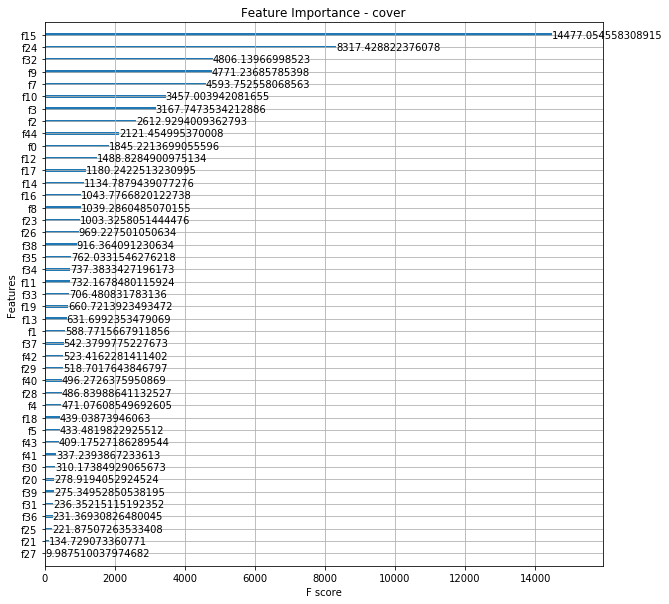

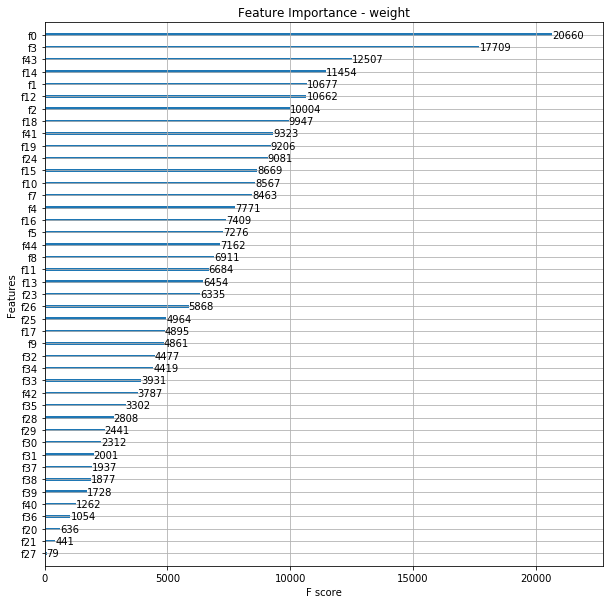

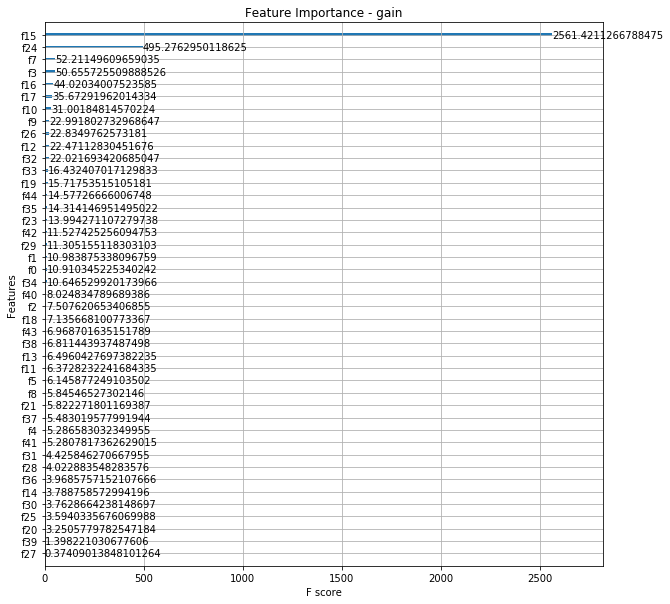

In [69]:
fig, ax = pyplot.subplots(figsize=(10,10))
plot_importance(model, importance_type='cover', title='Feature Importance - cover', ax=ax)
pyplot.show()
fig, ax = pyplot.subplots(figsize=(10,10))
plot_importance(model, importance_type='weight', title='Feature Importance - weight', ax=ax)
pyplot.show()
fig, ax = pyplot.subplots(figsize=(10,10))
plot_importance(model, importance_type='gain', title='Feature Importance - gain', ax=ax)
pyplot.show()

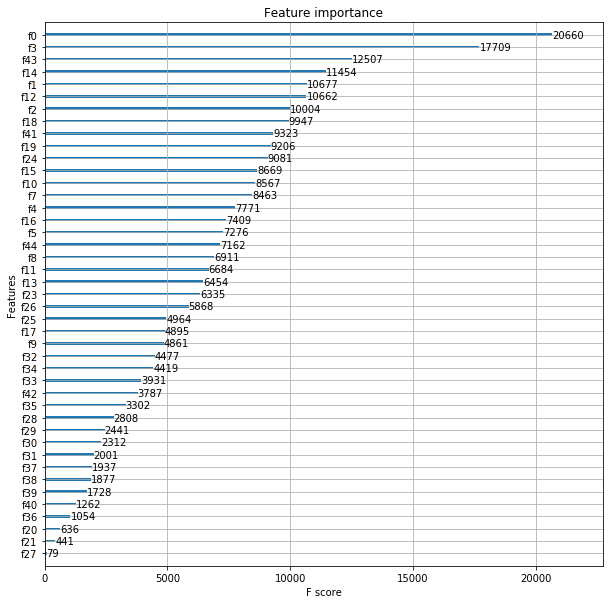

In [67]:
fig, ax = pyplot.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)
pyplot.show()

In [34]:
model.feature_importances_

AttributeError: 'Booster' object has no attribute 'feature_importances_'

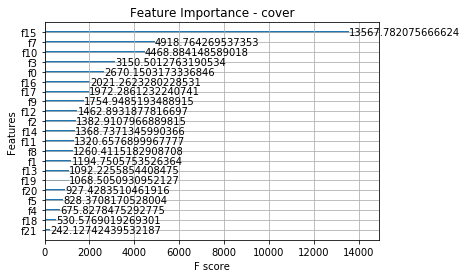

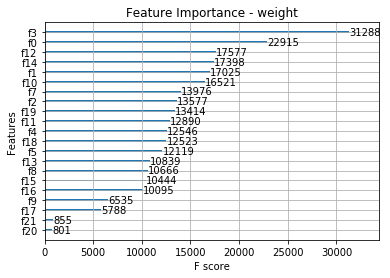

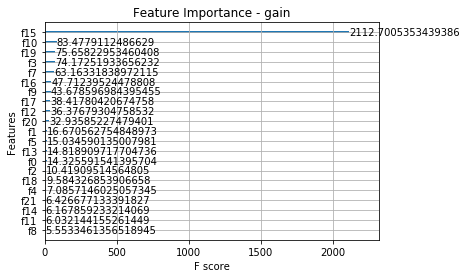

In [32]:
plot_importance(model, importance_type='cover', title='Feature Importance - cover')
pyplot.show()
plot_importance(model, importance_type='weight', title='Feature Importance - weight')
pyplot.show()
plot_importance(model, importance_type='gain', title='Feature Importance - gain')
pyplot.show()

In [2]:
import pickle
from xgboost import plot_tree
model_name = './no_poly_4900_6.mdl'
# with open(model_name, 'wb') as f:
#     pickle.dump(model, f)
model = pickle.load(open(model_name, 'rb'))
# plot_tree(model, num_trees=0)

In [3]:
from xgboost import plot_importance
from matplotlib import pyplot
from graphviz import Digraph

In [5]:
# from xgboost import plot_tree
# import matplotlib.pyplot as plt
from matplotlib import pyplot
# import pydot
# plt.figure(figsize=(20,15))
# xgb.plot_tree(model)
# plt.show()
# from matplotlib.pylab import rcParams
# xgb.plot_tree(model, num_trees=2)
##set up the parameters
# rcParams['figure.figsize'] = 10,5
# xgb.to_graphviz(model, num_trees=0)
plot_tree(model)
pyplot.show()
# xgb.to_graphviz(model, num_trees=0, rankdir='LR')

Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pic plain plain-ext pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json


CalledProcessError: Command '['dot', '-Tpng']' returned non-zero exit status 1.

In [96]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_err_ids_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)
doc_teams_all_dict = defaultdict(list)
doc_teams_errors_dict = defaultdict(list)
doc_men_ent_dict = defaultdict(dict)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     men, doc_id = fetch_mention_by_q_id(q_id)
    men, g_ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    
    if doc_id not in doc_men_ent_dict:
        for x in doc_ids:
            doc_men_ent_dict[x] = dict(fetch_men_ents_by_doc_id(x))
            for men_id, ent in doc_men_ent_dict[x].items():
                ent_labels = fetch_ent_cates_by_ent_id(escape_entity(ent))
                if ent_labels and "sports team" in ent_labels[0]:
                    doc_teams_all_dict[x].append(men_id)
    
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    
    
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    
    doc_err_ids_dict[doc_id].append(q_id)
    
    if q_id in doc_teams_all_dict[doc_id]:
        doc_teams_errors_dict[doc_id].append(q_id)
        
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(g_ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
PHOENIX 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
VANCOUVER 1186 NHL
LOS ANGELES 1186 NHL
VAIL 1349 ALPINE
TORONTO 1186 NHL
UAE 1163 SOCCER
MONTREAL 1186 NHL
EDS 1227 Electronic
MELBOURNE 1180 CRICKET
FSA 1274 BALANCE
ITALY 1164 RUGBY
DALLAS 1186 NHL
ST LOUIS 1186 NHL
RTRS 1331 RTRS
NEW YORK 1383 NBA
OTTAWA 1186 NHL
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1187 NHL
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
VAIL 1352 ALPINE
NEW YORK 1387 NHL
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
SYRIA 1165 SOCCER
ST LOUIS 1187 NHL
AUSTRALIA 1375 RUGBY
BARBARIANS 1375 RUGBY
VAIL 1345 ALPINE
INDIANAPOLIS 1188 NFL
CHARLOTTE 1383 NBA
WORLD CUP 1205 SOCCER
NEW YORK 1232 New
VANCOUVER 1383 NBA
ALBANIA 1377 SOCCER
ZULU 1212 GUNMEN
SACRAMENTO 1383 NBA
MELBOURNE 1183 CRICKET
NEW YORK 1234 Clean
WORLD SERIES 1178 CRICKET
VICTORIA 1378 CRICKET
WORLD GRAND PRIX 1184 BADMINTON
NEW JERSEY 1383 NBA
NEW YORK 1189 NBA
VANCOUVER 1383 NBA
ATLANTIC 1189 NBA
CHARLOTTE 1383 NBA
NEW 

In [192]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
#     sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     res[key+len(val)]
    men, doc_id = fetch_mention_by_q_id(q_id)
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
OAKLAND 1239 Russ
BOSTON 1385 NHL
BUFFALO 1385 NHL
WASHINGTON 1385 NHL
CHICAGO 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
TORONTO 1385 NHL
VANCOUVER 1186 NHL
PITTSBURGH 1385 NHL
MELBOURNE 1179 CRICKET
BUFFALO 1186 NHL
MONTREAL 1186 NHL
AUSTRALIA 1180 CRICKET
EDS 1227 Electronic
CHICAGO 1186 NHL
CUTTITTA 1164 RUGBY
FSA 1274 BALANCE
PHILADELPHIA 1186 NHL
ITALY 1164 RUGBY
DALLAS 1186 NHL
HOBART 1181 CRICKET
RTRS 1331 RTRS
OTTAWA 1186 NHL
CHICAGO 1386 NHL
ATLANTIC 1383 NBA
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1383 NBA
BOSTON 1187 NHL
PHILADELPHIA 1383 NBA
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
CENTRAL DIVISION 1383 NBA
SYRIA 1165 SOCCER
CHICAGO 1383 NBA
AUSTRALIA 1375 RUGBY
DETROIT 1383 NBA
BARBARIANS 1375 RUGBY
LOS ANGELES 1187 NHL
CLEVELAND 1383 NBA
ATLANTA 1383 NBA
INDIANA 1383 NBA
INDIANAPOLIS 1188 NFL
EUROLEAGUE 1172 BASKETBALL
WORLD CUP 1205 SOCCER
HOUSTON 1383 NBA
MINNESOTA 1383 NBA
NEW YORK 1232 

In [97]:
total_sports = 0
total_err_sports = 0
total_correct_sports = 0
for doc_id, mens in doc_err_dict.items():
    print('Doc ID: ' + doc_id)
    print('Total errors: ' + str(len(mens)) + '    total mentions: ' + str(doc_men_cnt_dict[doc_id]))
    total_sports += len(doc_teams_all_dict[doc_id])
    total_err_sports += len(doc_teams_errors_dict[doc_id])
    print('Total errors (sports teams): ' + str(len(doc_teams_errors_dict[doc_id])) + '    total mentions (sports teams):' + str(len(doc_teams_all_dict[doc_id])))
    print('All Errors mentions:\n{}'.format('\n'.join(mens)))
    print('Correct Mentions (sports teams):')
    correct_teams = [x for x in doc_teams_all_dict[doc_id] if x not in doc_teams_errors_dict[doc_id]]
    for q_id in correct_teams:
        total_correct_sports +=1
        men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
        print(str(q_id) + ": " + men + '->' + escape_entity(ent))
    print('\n')

Doc ID: 1310 U.S.
Total errors: 3    total mentions: 29
Total errors (sports teams): 0    total mentions (sports teams):0
All Errors mentions:
403839: Palestinian->State_of_Palestine->6->Palestinian_territories
403864: Palestinian->State_of_Palestine->6->Palestinian_territories
403865: Palestinian->State_of_Palestine->6->Palestinian_territories
Correct Mentions (sports teams):


Doc ID: 1297 London
Total errors: 1    total mentions: 13
Total errors (sports teams): 0    total mentions (sports teams):0
All Errors mentions:
403633: Fos->Fos-sur-Mer->2->Marseille
Correct Mentions (sports teams):


Doc ID: 1163 SOCCER
Total errors: 21    total mentions: 38
Total errors (sports teams): 15    total mentions (sports teams):19
All Errors mentions:
400495: JAPAN->Japan_national_football_team->2->Japan
400496: CHINA->China_PR_national_football_team->5->People's_Republic_of_China
400500: Japan->Japan_national_football_team->2->Japan
400501: Asian Cup->1996_AFC_Asian_Cup->3->AFC_Asian_Cup
400502: S

In [70]:
total_sports = 0
# total_err_sports = 0
# total_correct_sports = 0
for x, y in doc_teams_all_dict.items():
    total_sports += len(y)
    print(x)
#     doc_teams_all_dict[x].append(men_id)

1199 SOCCER
1208 SOCCER
943 SOCCER
424 SOCCER
1086 SOCCER
45 SOCCER
1191 NFL
537 SOCCER
146 BASEBALL
260 SOCCER
1079 BASKETBALL
1380 SOCCER
702 Rugby
136 CRICKET
1083 SOCCER
968 SOCCER
1115 SOCCER
319 MOTOR
1163 SOCCER
272 SOCCER
324 CRICKET
422 SOCCER
646 CRICKET
641 CYCLING
350 BASEBALL
337 SOCCER
354 SOCCER
1173 RUGBY
1104 SOCCER
242 MOTOR
640 CYCLING
55 SOCCER
154 SOCCER
139 SOCCER
1047 SOCCER
368 SOCCER
1064 SOCCER
1367 RUGBY
352 BASEBALL
411 CRICKET
179 Soccer
651 RUGBY
1050 SOCCER
1051 SOCCER
1377 SOCCER
1186 NHL
357 SOCCER
1393 SOCCER
340 SOCCER
1078 SOCCER
653 RUGBY
812 SOCCER
353 SOCCER
251 CRICKET
519 SOCCER
971 SOCCER
676 SOCCER
406 SOCCER
656 BASKETBALL
1069 SOCCER
674 SOCCER
664 BASEBALL
669 SOCCER
180 Soccer
675 SOCCER
680 SOCCER
131 MOTOR
275 SOCCER
1194 SOCCER
373 Australian
673 SOCCER
366 SOCCER
1366 SOCCER
46 SOCCER
259 SOCCER
1106 SOCCER
1172 BASKETBALL
1049 SOCCER
133 SOCCER
1202 SOCCER
268 SOCCER
134 SOCCER
1074 RUGBY
807 LOMBARDI
433 SOCCER
1053 SOCCER
265 SOCCER

In [163]:
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    print(literal_eval(res[key+np.argmax(val)][0])[1])
    break

John_Lewis_(department_store)


In [98]:
total_sports,total_err_sports,total_correct_sports

(747, 98, 649)

In [29]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

re_train_errs_list = []

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    re_train_errs_list.append(d_test[key: key + len(val),])

In [31]:
re_train_errs_list = np.array([y for x in re_train_errs_list for y in x])

In [32]:
re_train_errs_list

array([[  3.95657000e+05,   5.38699841e-03,   2.27000000e+02,
          9.66352165e-01,   1.44129634e-05,   1.22903721e+01,
          2.41088505e+01,   0.00000000e+00,   2.21415951e+01,
          4.17763426e+01,   1.69897000e+00,   4.82183793e-02,
          1.17646963e-01,   1.26847481e-02,   1.59468097e-02,
          4.91472388e-02,   1.00000000e+00],
       [  3.95657000e+05,   9.66352165e-01,   2.27000000e+02,
          9.66352165e-01,   1.75960339e-03,   7.72787276e+00,
          1.60356614e+01,   0.00000000e+00,   9.14542201e+00,
          1.73143251e+01,   1.09691001e+00,   6.05353448e-03,
          1.04339988e-02,   1.68593449e-03,   2.97329727e-03,
          3.56879173e-02,   0.00000000e+00]])

In [33]:
dtest_re = trans_data(re_train_errs_list)

[[  5.38699841e-03   2.27000000e+02   9.66352165e-01 ...,   1.26847481e-02
    1.59468097e-02   4.91472388e-02]
 [  9.66352165e-01   2.27000000e+02   9.66352165e-01 ...,   1.68593449e-03
    2.97329727e-03   3.56879173e-02]
 [  6.05688430e-03   2.27000000e+02   9.66352165e-01 ...,   5.64931261e-03
    1.02734407e-02   6.30971696e-02]
 ..., 
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   9.47476211e-03
    5.50338912e-02   1.66723449e-01]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   1.30768280e-02
    1.07783010e-02   8.24229005e-02]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   2.41756367e-02
    8.38351525e-02   2.13256234e-01]]
[ 1.  0.  0. ...,  0.  0.  0.]
[50 50  3 50 50 50 42  2  2 14  2 50  2 50 50  6  6 23 50 42  2 50 50 50 50
 50  2  3  2 12 50 50 50 50 50 50 44  8 50 17 50 50 14  8 50  2 50  7 50 50
 25  5 25  7  2 50  4 28 50 24 50  2  2 50  7 48 28 50 50 50 50 42 50  4  8
 50 50 50 50  4 10 50 17 24 19 50  4 50  5 20  5  4 50 50 50 

In [61]:
num_round=150
param = {'max_depth':6, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)

In [62]:
preds = model.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767


In [63]:
preds = model_new.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4372, precision: 0.9247038917089678, recall: 0.9125443539970779, f1: 0.9185838848618552


In [64]:
preds = model.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711


In [65]:
preds = model_new.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3884, precision: 0.8735942420152947, recall: 0.8659977703455964, f1: 0.8697794199977606


In [67]:
n_estimators = range(10, 200, 20)
max_depth = [2, 4, 6]
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)
        preds = model_new.predict(dtest)
        a = evalerror_detail_log(preds, dtest, 4791)
        print("correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767")
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('\n')
        print("correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711")
        preds = model_new.predict(dtest_b)
        a = evalerror_detail_log(preds, dtest_b, 4485)
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('________________________________________________________')

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4294, precision: 0.9082064297800339, recall: 0.8962638280108537, f1: 0.9021956087824351


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3950, precision: 0.8884390463337831, recall: 0.8807134894091416, f1: 0.8845593998432427
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4290, precision: 0.9073604060913706, recall: 0.8954289292423294, f1: 0.9013551843681058


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3954, precision: 0.8893387314439946, recall: 0.8816053511705686, f1: 0.8854551561975141
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805,

In [88]:
total_sports, total_err_sports, total_correct_sports

(966, 192, 624)

In [276]:
get_men_tokens_redis('aida_conll','1239 Russ')

{'': [4],
 '1996 - 12 - 06': [7],
 'a. curts cooke': [12],
 'chief': [15],
 'co inc': [9],
 'company': [23],
 'consulting': [21],
 'continue': [25],
 'cooke': [19],
 'director': [27],
 'effective july 1 , 1997': [18],
 'friday': [11],
 'gift': [29],
 'july': [3],
 'july 1 , 1998': [24],
 'maker': [30],
 'n.j.': [6],
 'oakland': [5],
 'officer': [17],
 'operating': [16],
 'president': [1, 14],
 'provide': [20],
 'retire': [2, 13],
 'russ berrie': [0, 8],
 'say': [10, 31],
 'serve': [26],
 'service': [22],
 'toy': [28]}

In [266]:
'john lewis partnership'.upper()

'JOHN LEWIS PARTNERSHIP'

In [1]:
import spacy

print(spacy.__version__)

2.0.2


In [2]:
nlp = spacy.load('en_core_web_md')

In [77]:
doc_text = '''Russ Berrie president to retire in July.
 OAKLAND, N.J. 1996-12-06
 Russ Berrie and Co Inc said on Friday that A. Curts Cooke will retire as president and chief operating officer effective July 1, 1997.
 Cooke will provide consulting services to the company through July 1, 1998, and will continue to serve as a director, the toy and gift maker said.
 '''

In [78]:
doc = nlp(doc_text)

In [80]:
from collections import defaultdict
filter_ent_types = ('DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL')
x = defaultdict(list)
for ent in doc.ents:
    if ent.label_ not in filter_ent_types:
        x[ent.text].append(ent.start_char)
    print(ent, ent.label_)

Russ Berrie PERSON
July DATE
OAKLAND ORG
N.J. GPE
1996 DATE
Russ Berrie PERSON
Co Inc ORG
Friday DATE
A. Curts Cooke PERSON
July 1, 1997 DATE
Cooke PERSON
July 1, 1998 DATE


In [81]:
x

defaultdict(list,
            {'A. Curts Cooke': [111],
             'Co Inc': [84],
             'Cooke': [204],
             'N.J.': [51],
             'OAKLAND': [42],
             'Russ Berrie': [0, 68]})

In [104]:
a = np.array([0.3,  0.3,  0. ,  0.3,  0.3,  0. ])

In [105]:
b = np.array([True, True, False, True, True, False], dtype=np.bool)

In [16]:
a = np.array([[2,  0.1, 1], [1,  0.3, 1],  [1 ,  0.4, 0], [3, 1,1], [3, 2, 0]])
b = np.array([[1,  0, 1],  [1 ,  4, 0],  [2,  1, 1], [3, 0.1,1], [3, 0.2, 0]])

In [60]:
def combine_features(original_feas, new_features):
    men_id_feas_dict = defaultdict(list)
    for fea in new_features:
        men_id_feas_dict[fea[0]].append(fea)
    comb_feas = None
    pre_men_id = 0
#     print(men_id_feas_dict)
    for fea_idx, fea in enumerate(original_feas):
#         print(fea_idx)
        if pre_men_id == fea[0]:
            continue
        else:
            pre_men_id = fea[0]
            fea_size = len(men_id_feas_dict[fea[0]])
#             print(pre_men_id)
#             print(fea_size)
#             print(original_feas[fea_idx: fea_idx + fea_size, :-1])
#             s = men_id_feas_dict[fea[0]]
#             print(np.array(s)[:, 1:])
            res = np.append(original_feas[fea_idx: fea_idx + fea_size, :-1], np.array(men_id_feas_dict[fea[0]])[:, 1:], axis=1)
            comb_feas = np.concatenate((comb_feas, res), axis=0) if comb_feas is not None else res
    return comb_feas

In [61]:
combine_features(a, b)

array([[ 2. ,  0.1,  1. ,  1. ],
       [ 1. ,  0.3,  0. ,  1. ],
       [ 1. ,  0.4,  4. ,  0. ],
       [ 3. ,  1. ,  0.1,  1. ],
       [ 3. ,  2. ,  0.2,  0. ]])

In [75]:
a = np.array([[2,  0.1, 1], [1,  0.3, 1],  [1 ,  0.4, 0], [3, 1,1], [3, 2, 0]])
b = np.array([[1,  0, 1],  [1 ,  4, 0],  [2,  1, 1], [3, 0.1,1], [3, 0.2, 0]])

In [76]:
np.concatenate((a, b), axis=0)

array([[ 2. ,  0.1,  1. ],
       [ 1. ,  0.3,  1. ],
       [ 1. ,  0.4,  0. ],
       [ 3. ,  1. ,  1. ],
       [ 3. ,  2. ,  0. ],
       [ 1. ,  0. ,  1. ],
       [ 1. ,  4. ,  0. ],
       [ 2. ,  1. ,  1. ],
       [ 3. ,  0.1,  1. ],
       [ 3. ,  0.2,  0. ]])

In [84]:
import spacy
from spacy import displacy

ex = {'text': 'But Google is starting from behind.',
       'ents': [{'start': 4, 'end': 10, 'label': 'ORG'}],
       'title': None}
html = displacy.render(ex, style='ent', manual=True)

In [85]:
print(html)

<div class="entities" style="line-height: 2.5">But 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">
    Google
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 is starting from behind.</div>


In [120]:
import re
doc = '[[Beij,. "(ing]] is a [[city]].'

In [127]:
for m in re.finditer(r'\[\[([^\]])*\]\]', doc):
    print(m.start(), m.end())

0 16
22 30


In [129]:
len(doc.split())

5

In [125]:
ss = conn.hmget('men-ner-stanford-aida_conll', '1163 SOCCER')[0]

In [128]:
ss = json.loads(ss)

In [129]:
ss.keys()

dict_keys(['nader jokhadar', 'bitar', 'kuwait', 'nadim ladki', 'world cup', 'shu kamo', 'oleg shatskiku', 'hiroshige yanagimoto', 'asian games', 'fifa', 'syrian', 'uzbek', 'hassan abbas', 'united arab emirates', 'uzbekistan', 'chinese', 'indonesia', 'china', 'soviet', 'salem bitar', 'al-ain', 'takuya takagi', 'japan', 'south korea', 'syrians', 'igor shkvyrin', 'syria', 'asian cup'])

In [142]:
import spacy

nlp = spacy.load('en_core_web_md')

In [167]:
s = nlp('Emirates')

In [168]:
for t in s:
    print(t.lemma_)

emirate


In [158]:
import inflect
p = inflect.engine()

In [148]:
p.singular_noun('United Arab Emirates')

'syrian'